In [59]:
# Import libraries/packages and load data 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pathlib
from datetime import datetime 
import mplfinance as mpl
import seaborn as sns

# DATA folder
CSV_FILE = '../data/csv/kraken_ohlc/XBTUSD_1440.csv'

data = pd.read_csv(CSV_FILE, names=['timestamp','open','high','low','close','volume','count'])

# Data Cleanup 
data['source'] = 'kraken'
data['interval'] = '1d'
data['trade_pair'] = 'BTCUSD'
data['trade_date'] = pd.to_datetime(data['timestamp'], unit='s')
data['trade_timestamp'] = data['trade_date'].dt.strftime('%Y-%m-%d %H:%M:%S')
data['volume_quote'] = data['volume'] * data['close']

data.head()

,timestamp,open,high,low,close,volume,count,source,interval,trade_pair,trade_date,trade_timestamp,volume_quote
0,1381017600,122.00000,122.00000,122.00,122.00,0.1000,1,kraken,1d,BTCUSD,2013-10-06,2013-10-06 00:00:00,12.200000
1,1381104000,123.61000,123.61000,123.61,123.61,0.1000,1,kraken,1d,BTCUSD,2013-10-07,2013-10-07 00:00:00,12.361000
2,1381190400,123.91000,124.19000,123.90,124.18,3.9916,4,kraken,1d,BTCUSD,2013-10-08,2013-10-08 00:00:00,495.676888
3,1381276800,124.01687,124.01687,123.84,123.84,2.8230,3,kraken,1d,BTCUSD,2013-10-09,2013-10-09 00:00:00,349.600320
4,1381363200,125.85000,125.86000,125.85,125.86,2.0000,2,kraken,1d,BTCUSD,2013-10-10,2013-10-10 00:00:00,251.720000


### 1. Line chart for closing prices 

Plot the closing prices over time to get an initial sense of the overall trend of the cryptocurrency.

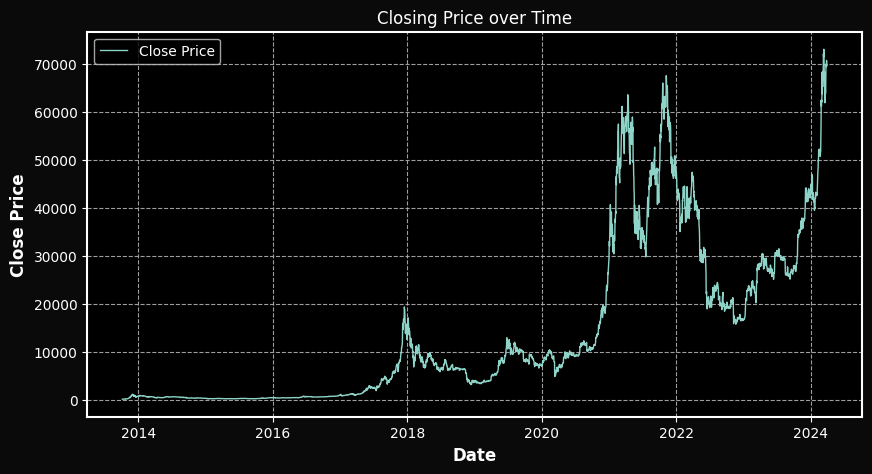

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(data['trade_date'], data['close'], label='Close Price')
plt.title('Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 2. CandleStick Charts 

Visualize the OHLC data, showing the opening, high, low, and closing prices for each period. This helps in identifying price patterns and trends.


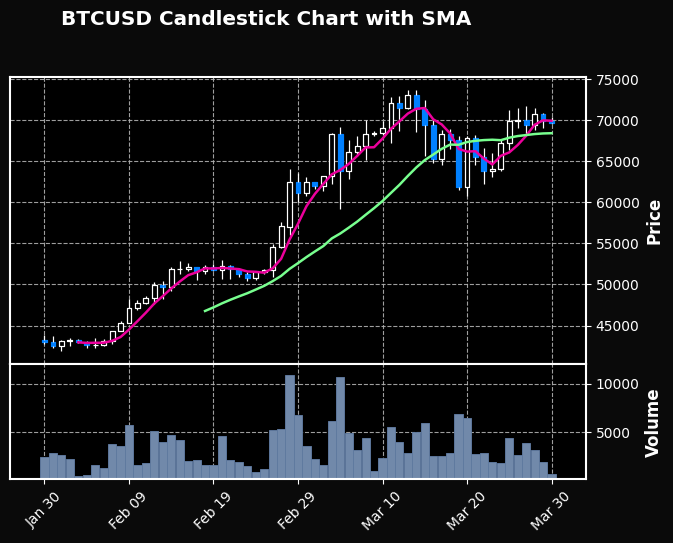

In [61]:
data2=data.copy()
data2.set_index('trade_date', inplace=True)
date_start = data2.index.max() - pd.DateOffset(months=2)
data_ytd = data2.loc[date_start:]

# Apply Seaborn styling
sns.set(style='whitegrid')
# Prepare data for mplfinance
data_mpf = data_ytd[['open', 'high', 'low', 'close', 'count', 'volume']]

# Plot candlestick chart with mplfinance
mpl.plot(data_mpf, type='candle', mav=(5, 20), volume=True, style='mike', title='BTCUSD Candlestick Chart with SMA')


### 3. Summary Statistics 

- **Descriptive Statistics**: Calculate mean, median, standard deviation, and other summary statistics for the opening, high, low, and closing prices.

- **Volatility**: Measure the volatility of the cryptocurrency using standard deviation or other metrics like Average True Range (ATR).

In [63]:
data_ohlcv = data[['open', 'high', 'low', 'close', 'volume', 'count']]
summary_stats = data_ohlcv.describe()
print(summary_stats)

               open          high           low         close        volume  \
count   3817.000000   3817.000000   3817.000000   3817.000000   3817.000000   
mean   14241.378287  14608.256977  13839.706844  14259.549134   3638.506710   
std    16959.144644  17392.234983  16474.021033  16981.499798   3921.261840   
min      122.000000    122.000000    122.000000    122.000000      0.000038   
25%      644.900000    660.000000    627.590000    646.000000    709.369953   
50%     7383.400000   7599.000000   7215.000000   7394.000000   2743.908282   
75%    23313.900000  23829.300000  22845.700000  23325.700000   5152.104964   
max    73089.700000  73734.000000  71336.100000  73082.400000  45110.873425   

               count  
count    3817.000000  
mean    18056.885512  
std     19979.023092  
min         1.000000  
25%       900.000000  
50%     14345.000000  
75%     26434.000000  
max    238569.000000  


### 4. Moving Averages

- **Simple Moving Average (SMA)**: Calculate SMAs for different periods (e.g., 10-day, 50-day) to smooth out price data and identify trends.

- **Exponential Moving Average (EMA)**: Calculate EMAs to give more weight to recent prices, providing a responsive trend indicator.

In [66]:
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['SMA_50'] = data['close'].rolling(window=50).mean()

print(data[['timestamp','SMA_10', 'SMA_50']].tail())

       timestamp    SMA_10     SMA_50
3812  1711411200  66621.85  59592.066
3813  1711497600  66730.02  60119.112
3814  1711584000  67044.24  60647.284
3815  1711670400  67845.11  61139.034
3816  1711756800  68023.71  61589.534


### 5. Volume Analysis

- **Volume Charts**: Plot trading volume over time to identify periods of high activity, which often precedes significant price movements.

- **Volume Weighted Average Price (VWAP)**: Calculate and plot VWAP to understand the average price a security has traded at throughout the day, based on both volume and price.

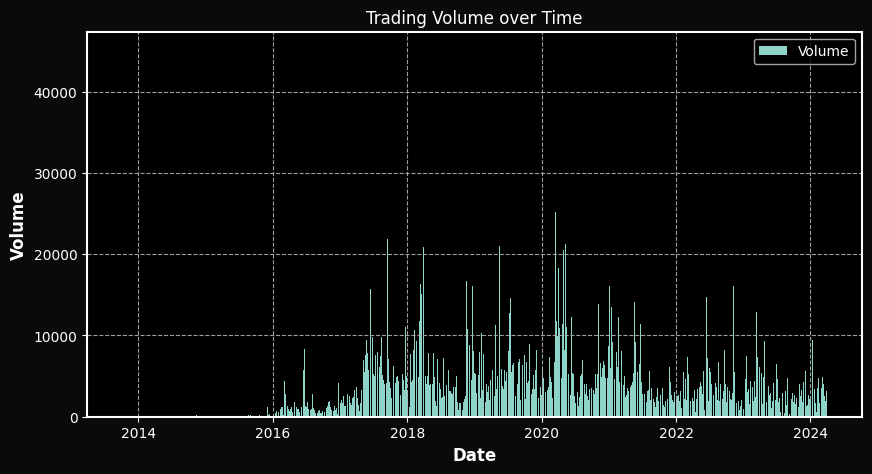

In [67]:
plt.figure(figsize=(10, 5))
plt.bar(data['trade_date'], data['volume'], label='Volume')
plt.title('Trading Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### 6. Relative Strength Index (RSI)

Calculate and plot the RSI to identify overbought or oversold conditions in the market, which can indicate potential reversal points.

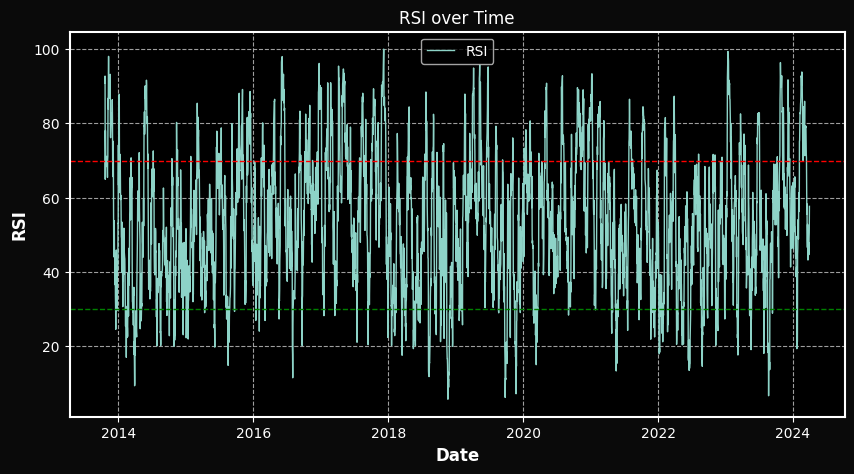

In [68]:
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data['close'])

plt.figure(figsize=(10, 5))
plt.plot(data['trade_date'], data['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

### 7. Bollinger Bands

Plot Bollinger Bands around the price data to visualize price volatility and identify potential overbought or oversold conditions.

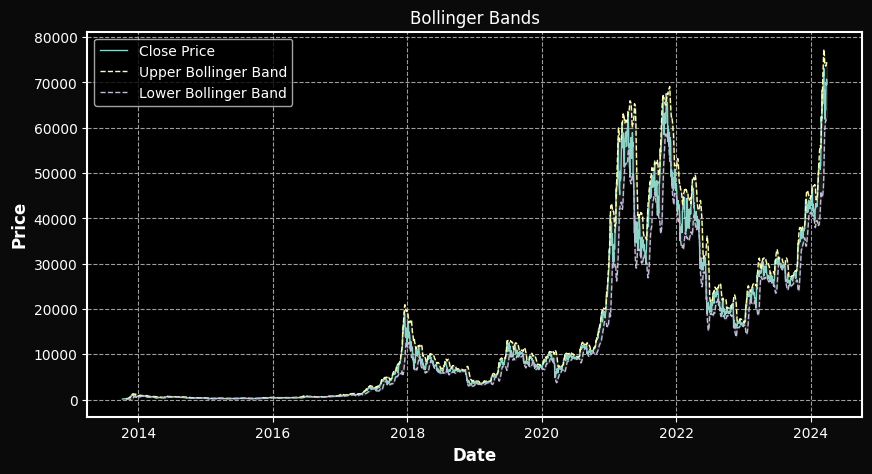

In [69]:
window = 20
rolling_mean = data['close'].rolling(window=window).mean()
rolling_std = data['close'].rolling(window=window).std()

data['Upper Band'] = rolling_mean + (rolling_std * 2)
data['Lower Band'] = rolling_mean - (rolling_std * 2)

plt.figure(figsize=(10, 5))
plt.plot(data['trade_date'], data['close'], label='Close Price')
plt.plot(data['trade_date'], data['Upper Band'], label='Upper Bollinger Band', linestyle='--')
plt.plot(data['trade_date'], data['Lower Band'], label='Lower Bollinger Band', linestyle='--')
plt.fill_between(data['trade_date'], data['Upper Band'], data['Lower Band'], color='gray', alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 8. MACD (Moving Average Convergence Divergence)

Calculate and plot the MACD line along with the signal line to identify trend direction and potential buy/sell signals.

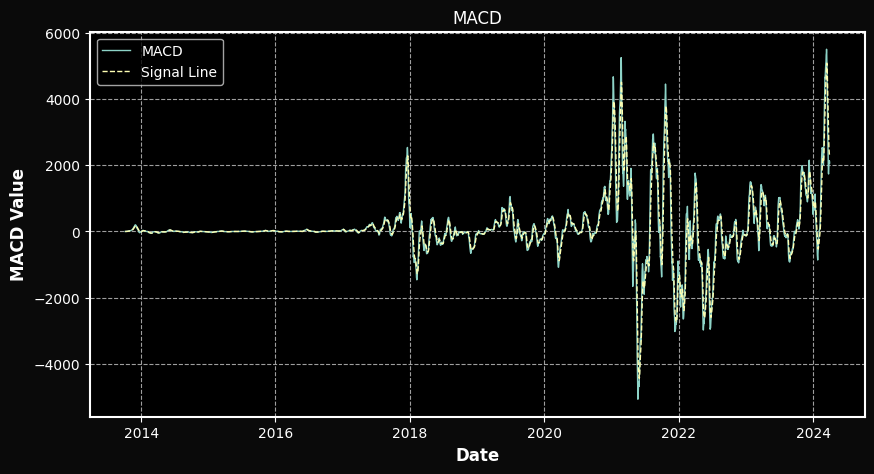

In [70]:
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

data['MACD'], data['Signal'] = calculate_macd(data['close'])

plt.figure(figsize=(10, 5))
plt.plot(data['trade_date'], data['MACD'], label='MACD')
plt.plot(data['trade_date'], data['Signal'], label='Signal Line', linestyle='--')
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

### 9. Support and Resistance Levels

Identify Key Levels: Plot horizontal lines at historical support and resistance levels to see where price has previously reversed or consolidated.

KeyError: Timestamp('2013-10-15 00:00:00')

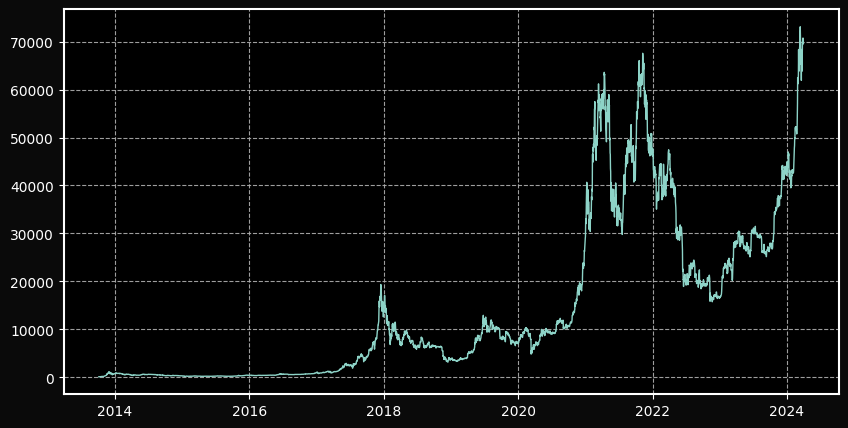

In [72]:
def is_support(data, i):
    return data['low'][i] < data['low'][i - 1] and data['low'][i] < data['low'][i + 1] and \
           data['low'][i] < data['low'][i - 2] and data['low'][i] < data['low'][i + 2]

def is_resistance(data, i):
    return data['high'][i] > data['high'][i - 1] and data['high'][i] > data['high'][i + 1] and \
           data['high'][i] > data['high'][i - 2] and data['high'][i] > data['high'][i + 2]

levels = []
for i in range(2, len(data) - 2):
    if is_support(data, i):
        levels.append((data['trade_date'][i], data['low'][i]))
    elif is_resistance(data, i):
        levels.append((data['trade_date'][i], data['high'][i]))

plt.figure(figsize=(10, 5))
plt.plot(data['trade_date'], data['close'], label='Close Price')
for level in levels:
    plt.axhline(level[1], color='green' if data['low'][level[0]] == level[1] else 'red', linestyle='--', alpha=0.7)
plt.title('Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### 10. Trend Lines and Channels

Draw Trend Lines: Identify and draw trend lines to visualize the direction of the market and potential reversal points.

Price Channels: Create price channels by drawing parallel lines above and below the trend line to identify trading ranges.

In [73]:
def draw_trend_lines(data, distance=50):
    peaks, _ = find_peaks(data['close'], distance=distance)
    troughs, _ = find_peaks(-data['close'], distance=distance)

    plt.figure(figsize=(10, 5))
    plt.plot(data['trade_date'], data['close'], label='Close Price')
    plt.plot(data['trade_date'][peaks], data['close'][peaks], "x", label='Peaks')
    plt.plot(data['trade_date'][troughs], data['close'][troughs], "o", label='Troughs')
    plt.title('Trend Lines and Channels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

draw_trend_lines(data)

NameError: name 'find_peaks' is not defined

### 11. Correlation Analysis

Correlation with Other Assets: Calculate the correlation between the cryptocurrency and other assets (e.g., other cryptocurrencies, stocks) to understand how they move relative to each other.

In [78]:
# Assuming you have another OHLC dataset for comparison
data_other = pd.read_csv('../data/csv/kraken_ohlc/ETHUSD_1440.csv', names=['timestamp','open','high','low','close','volume','count'])
data_other['source'] = 'kraken'
data_other['interval'] = '1d'
data_other['trade_pair'] = 'BTCUSD'
data_other['trade_date'] = pd.to_datetime(data_other['timestamp'], unit='s')
data_other['trade_timestamp'] = data_other['trade_date'].dt.strftime('%Y-%m-%d %H:%M:%S')
data_other['volume_quote'] = data_other['volume'] * data_other['close']

# Convert timestamp to datetime for other dataset
data_other['trade_date'] = pd.to_datetime(data_other['timestamp'], unit='s')

# Calculate daily returns
data['BTC_Return'] = data['close'].pct_change()
data_other['Other_Return'] = data_other['close'].pct_change()

# Merge the two dataframes on date
returns = pd.merge(data[['trade_date', 'BTC_Return']], data_other[['trade_date', 'Other_Return']], on='trade_date')

# Calculate correlation
correlation = returns.corr()

print(correlation)

              trade_date  BTC_Return  Other_Return
trade_date      1.000000   -0.018597     -0.036991
BTC_Return     -0.018597    1.000000      0.558976
Other_Return   -0.036991    0.558976      1.000000


### 12. Seasonality and Patterns

Seasonal Trends: Analyze if there are any recurring patterns or seasonal trends in the price data.

Pattern Recognition: Identify common price patterns such as head and shoulders, triangles, flags, and pennants.

### 13. Distribution Analysis

Histogram: Plot histograms of returns to understand the distribution and identify any skewness or kurtosis.

Box Plots: Use box plots to visualize the distribution of the OHLC prices and identify outliers.

### Tools and Libraries

Python Libraries: Use libraries like pandas, matplotlib, seaborn, plotly, and mplfinance for data manipulation and visualization.

Technical Analysis Libraries: Libraries like ta-lib or btalib provide a wide range of built-in functions for technical indicators.